# Trailer: Bio-image Analysis with Python
In the following chapters we will dive into image analysis, machine learning and bio-statistics using Python. This first notebook serves as a trailer of what we will be doing.

Python notebooks typically start with the imports of Python libraries which the notebook will use. The reader can check first if all those libraries are installed before going through the whole notebook.

In [2]:
    import numpy as np
    from skimage.io import imread, imshow
    import pyclesperanto_prototype as cle
    from skimage import measure
    import pandas as pd
    import seaborn
    import apoc
    import stackview

## Working with image data
We start with loading the image data of interest. In this example we load an image showing a zebrafish eye, courtesy of Mauricio Rocha Martins, Norden lab, MPI CBG Dresden.

[[14709 17195 15101 ... 10977 10615 10864]
 [15234 16786 16048 ... 11350 11110 11061]
 [15709 15896 16645 ... 11334 10853 10584]
 ...
 [22707 22025 23783 ... 16773 17757 16991]
 [22484 24699 21860 ... 16546 16348 17791]
 [23357 21872 23148 ... 18280 18107 17240]]
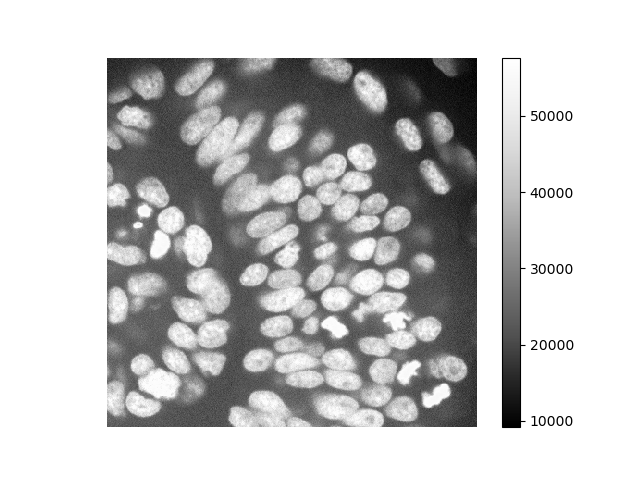
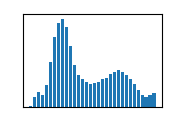

In [3]:
# open an image file
multichannel_image = imread("../../data/zfish_eye.tif")

# extract a channel
single_channel_image = multichannel_image[:,:,0]

cropped_image = single_channel_image[200:600, 500:900]

stackview.insight(cropped_image)

## Image filtering

A common step when working with fluorescence microscopy images is subtracting background intensity, e.g. resulting from out-of-focus light. This can improve image segmentation results further down in the workflow.

[[1279. 3765. 1671. ... 1790. 1428. 1677.]
 [1804. 3356. 2618. ... 2163. 1923. 1874.]
 [2279. 2466. 3215. ... 2147. 1666. 1397.]
 ...
 [1608.  926. 2684. ... 1342. 2326. 1560.]
 [1385. 3600.  761. ... 1115.  917. 2360.]
 [2280.  795. 2071. ... 2849. 2676. 1809.]]
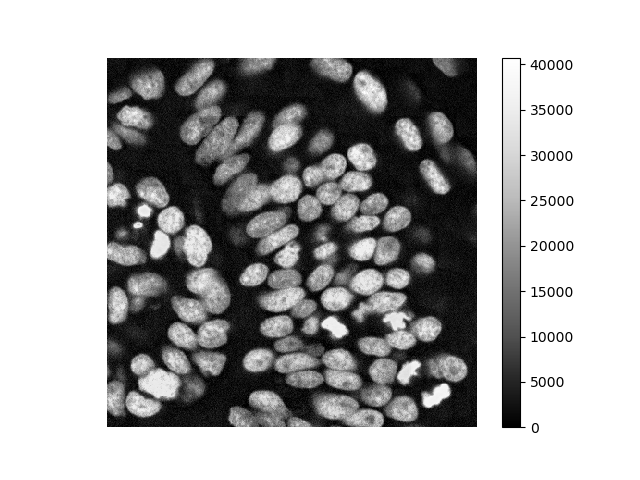
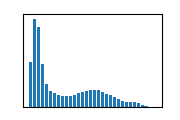

In [4]:
# subtract background using a top-hat filter
background_subtracted_image = cle.top_hat_box(cropped_image, radius_x=20, radius_y=20)

stackview.insight(background_subtracted_image)

## Image segmentation
For segmenting the nuclei in the given image, a huge number of algorithms exist. Here we use a classical approach named Voronoi-Otsu-Labeling, which is certainly not perfect.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
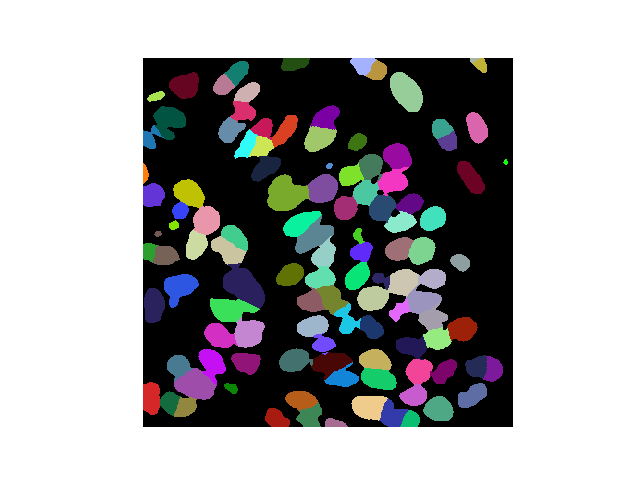

In [5]:
label_image = np.asarray(cle.voronoi_otsu_labeling(background_subtracted_image, spot_sigma=4))

# show result
stackview.insight(label_image)

## Measurements and feature extraction
After the image is segmented, we can measure properties of the individual objects. Those properties are typically descriptive statistical parameters, called features. When we derive measurements such as the area or the mean intensity, we extract those two features.

In [6]:
statistics = measure.regionprops_table(label_image, 
                                       intensity_image=cropped_image,
                                       properties=('area', 'mean_intensity', 'major_axis_length', 'minor_axis_length'))

## Working with tables
The `statistics` object created above contains a Python data structure, a dictionary of measurement vectors, which is not most intuitive to look at. Hence, we convert it into a table. Data scientists often call these tables DataFrames, which are available in the [pandas](https://pandas.pydata.org/) library.

In [7]:
dataframe = pd.DataFrame(statistics)

We can use existing table columns to compute other measurements, such as the `aspect_ratio`.

In [8]:
dataframe['aspect_ratio'] = dataframe['major_axis_length'] / dataframe['minor_axis_length']
dataframe

,area,mean_intensity,major_axis_length,minor_axis_length,aspect_ratio
0,294.0,36604.625850,25.656180,18.800641,1.364644
1,91.0,37379.769231,20.821990,6.053507,3.439658
2,246.0,44895.308943,21.830827,14.916032,1.463581
3,574.0,44394.637631,37.788705,19.624761,1.925563
4,518.0,45408.903475,26.917447,24.872908,1.082199
...,...,...,...,...,...
108,568.0,48606.121479,37.357606,19.808121,1.885974
109,175.0,25552.074286,17.419031,13.675910,1.273702
110,460.0,39031.419565,26.138592,23.522578,1.111213
111,407.0,39343.292383,28.544027,19.563792,1.459023


## Plotting
Measurements can be visualized using plots.

<Axes: xlabel='area', ylabel='aspect_ratio'>

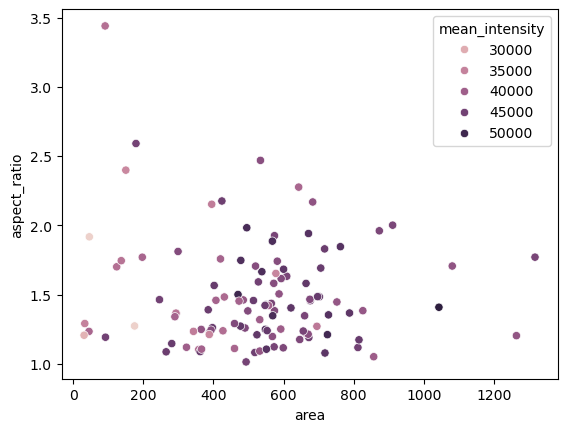

In [9]:
seaborn.scatterplot(dataframe, x='area', y='aspect_ratio', hue='mean_intensity')

## Descriptive statistics
Taking this table as a starting point, we can use statistics to get an overview about the measured data.

In [10]:
mean_area = np.mean(dataframe['area'])
stddev_area = np.std(dataframe['area'])

print("Mean nucleus area is", mean_area, "+-", stddev_area, "pixels")

Mean nucleus area is 524.4247787610619 +- 231.74703195433014 pixels


## Classification
For better understanding the internal structure of tissues, but also to correct for artifacts in image processing workflows, we can classify cells, for example according to their size and shape.

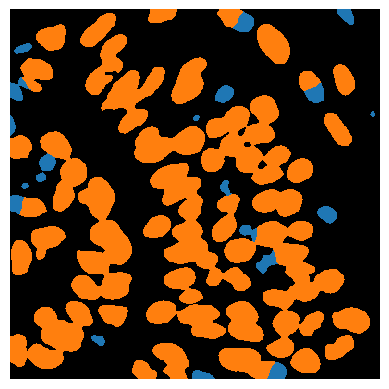

In [11]:
object_classifier = apoc.ObjectClassifier('../../data/blobs_classifier.cl')
classification_image = object_classifier.predict(label_image, cropped_image)

stackview.imshow(classification_image)